In [2]:
from collections import defaultdict
import csv
import numpy as np

POLICIES = [
    ("0", "1"),
    ("0", "0"),
    ("-2", "1"),
    ("-2", "0"),
    ("-1", "1"),
    ("-1", "0"),
]
LABELS = {
    ("0", "0"): "GCS, local",
    ("0", "1"): "GCS, remote",
    ("-2", "0"): "No FT, local",
    ("-2", "1"): "No FT, remote",
    ("-1", "0"): "Lineage stash, local",
    ("-1", "1"): "Lineage stash, remote",
}

def get_latencies(directory):
    all_latencies = {}
    for policy in POLICIES:
        all_latencies[policy] = defaultdict(lambda: defaultdict(list))
    with open('/home/stephanie/ray-fork/results/{}/min_latency.csv'.format(directory), 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = int(row['throughput'])
            policy = (row['gcs'], row['remote'])
            num_shards = int(row['num_shards'])
            if policy in all_latencies:
                latencies = all_latencies[policy][num_shards]
                latencies[key].append(float(row['min_latency']) * 1000 / 2)
    return all_latencies

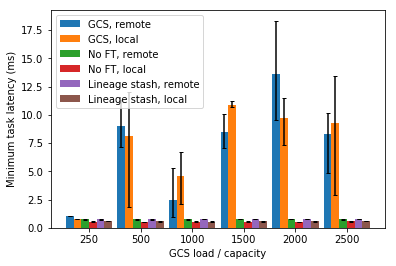

In [7]:
import matplotlib.pyplot as plt

DIRECTORY = "latencies-square"
WIDTH = 0.9 / len(POLICIES)
MAX_X = 4000

CAPACITIES = {
    1: 750,
    2: 0,
    4: 1250,
}

def plot_line(plt, results, label, num_shards, index=None):
    results = results[num_shards]
    ticks = np.array([x for x in sorted(results.keys()) if x <= MAX_X])
    means = []
    yerr_low = []
    yerr_high = []
    for tick in ticks:
        mean = np.mean(results[tick])
        means.append(mean)
        yerr_low.append(
            mean - np.quantile(results[tick], 0.025)
        )
        yerr_high.append(
            np.quantile(results[tick], 0.975) - mean
        )
    x = np.arange(len(ticks))
    plt.bar(x + index * WIDTH, means, yerr=[yerr_low, yerr_high], width=WIDTH, label=label, capsize=2)
#     ticks = ticks / CAPACITIES[1]
    plt.xticks(x + WIDTH * (len(POLICIES) - 1) / 2, ticks)

NUM_SHARDS = 4
all_latencies = get_latencies(DIRECTORY)
for i, policy in enumerate(POLICIES):
    plot_line(plt, all_latencies[policy], LABELS[policy], NUM_SHARDS, index=i)

plt.xlabel("GCS load / capacity")
plt.ylabel("Minimum task latency (ms)")
plt.legend()
plt.show()

# plt.savefig("/home/stephanie/ray-fork/results/{}/min_latency-1-shards.pdf".format(DIRECTORY))